Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.


<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>


---


# Lab Session 11: Dimensionality Reduction with AutoEncoders

J.B. Scoggins - Adrien Ehrhardt - Johannes Lutzeyer


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
from tensorflow.keras.layers import (
    Dense,
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras import Model

import keras  # used in tests


2023-05-03 20:49:57.447637: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-03 20:49:57.481370: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 20:49:57.613737: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 20:49:57.614598: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 20:49:58.536330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Introduction

In this lab, you will get hands-on experience with dimension reduction using Undercomplete Autoencoders. The goal of dimension reduction is to find a suitable transformation which converts a high-dimensional space into a smaller feature space, such that the important information is not lost, but the visualization and interpretability are easier.


## Recall the original MNIST Dataset and PCA decomposition

We will reuse the MNIST digits dataset throughout this excercise. Recall that the original MNIST dataset provides $60{,}000$ 28x28 pixels (in grayscale) training images of hand-written digits 0-9. The images are labeled with integer values 0-9. The training set has become the _de facto_ image classification example due to its small size.

In this exercise, we are not interested in classifying images of digits. Instead, we will think of the images as defining a 28x28 = 784 element feature space. In this context, we are interested in transforming the 784 parameters into a smaller set of transformed coordinates.

Recall from [lab_session_10](https://adimajo.github.io/CSE204-2022-admin/lab_session_10.html) that we used the keras datasets module to load the MNIST dataset, normalize it, and get to know how it is structured.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train_reshaped = x_train.reshape(60000, 784)

The shape of `x_train`, `x_train_reshaped` and `y_train` correspond to what we expect:


In [3]:
print(x_train.shape)  # 28 by 28 pixels
print(x_train_reshaped.shape)  # flattened 28 by 28 = 784 "pixels"
print(y_train.shape)  # one column of labels {0, ..., 9}

(60000, 28, 28)
(60000, 784)
(60000,)


We can plot a few images using `matplotlib.pyplot`:


(-0.5, 27.5, 27.5, -0.5)

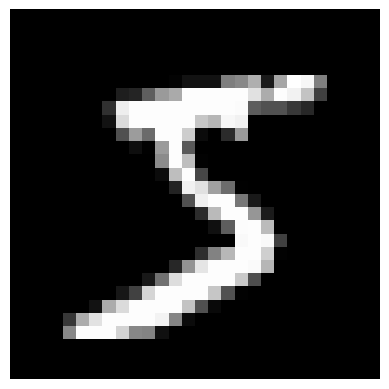

In [4]:
plt.imshow(x_train[0, :, :], cmap="gray")
plt.axis("off")


## Principal Component Analysis (PCA) - taken from [lab_session_10](https://adimajo.github.io/CSE204-2022-admin/lab_session_10.html)

The goal of PCA is to perform an orthogonal transformation which converts a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables, called _principal components_. This can be thought of as fitting a $p$-dimensional ellipsoid to the observations.

Let's consider a dataset $X\in R^{n\times p}$, where $n$ is the number of observations and $p$ the number of variables. PCA transforms $X$ into a new coordinate system (new variable set), such that the greatest variance in the data is captured in the first coordinate, and then the second, and so on. More specifically, the transformed coordinates $T \in R^{n\times p}$ are written as a linear combination of the original dataset,

$$ T = X W, $$

where $W \in R^{p\times p}$ is the transformation matrix. The first column of $W$, denoted as $w_1$, is constructed to maximize the variance of the transformed coordinates.

$$ w*1 = \underset{\|w\|=1}{\operatorname{argmax}} \sum*{i=1}^{n} (t_1)\_i^2 = \underset{\|w\|=1}{\operatorname{argmax}} \| X w \|\_2^2 = \underset{\|w\|=1}{\operatorname{argmax}} \frac{w^T X^T X w}{w^T w} $$

The ratio in the last term is known as the [_Rayleigh quotient_](https://en.wikipedia.org/wiki/Rayleigh_quotient). It is well known that for the positive, semidefinite matrix $X^T X$, the largest value of the Rayleigh quotient is given as the largest eigenvalue of the matrix, where $w$ is eigenvector associated with that eigenvalue.

The remaining columns of $W$ can be found by finding the the next orthogonal linear combination which maximizes the variance of the data, minus the previously transformed coordinates.

$$ w*k = \underset{\|w\|=1}{\operatorname{argmax}} \| (X - \sum*{s=1}^{k-1} X w_s w_s^T) w \|^2_2 $$

Practically, the columns of $W$ are typically computed as the eigenvectors of $X^T X$ ordered by their corresponding eigenvalues in descending order.

### Singular Value Decomposition

The Singular Value Decomposition of a matrix $X \in R^{n\times p}$ is given as

$$ X = U \Sigma W^T, $$

where $\Sigma \in R^{n\times p}$ is a rectangular diagonal matrix of positive values known as the the singular values, of $X$, $\sigma(X)$, and $U \in R^{n\times n}$ and $W \in R^{p\times p}$ are orthonormal matrices, whose columns are the left and right (respectively) singular vectors of the matrix $X$. Using this decomposition, we can easily see that

$$ X^T X = W \hat{\Sigma} W^T, $$

where $\hat{\Sigma}$ is a square diagonal matrix of the squared singular values of $X$. Comparing this to the eigenvalue decomposition of $X^T X = Q \Lambda Q^T$, we see that the singular values of $X$ represent the square-root of the eigenvalues of $X^T X$, and the singular vectors of $X$ are simply the eigenvectors of $X^T X$. Therefore, we can perform PCA on a data matrix $X$ by computing its right singular vector matrix, $W$.

### Dimensionality Reduction

We can reduce the dimensionality of our data by truncating the transformed variables to include only a subset of those variables with the highest variance. For example, if we keep the first $L <= p$ variables, the reduced transformation reads

$$ T_L = X W_L, $$

where $W_L \in R^{n\times L}$ is the eigenvector matrix as before, but taking only the first $L$ columns. This technique has been widely used to reduce the dimension of large-dimensioned datasets by accounting for the directions of largest variance in the data, while neglecting the other directions. In addition, this can also be used to remove noise from a dataset, in which it is assumed that the noise accounts for a small degree of variance, compared to the true underlying parameterization. Finally, using PCA to find the 2 highest varying parameters can also allow us to visualize a high-dimensional dataset.


### Reconstruct Images

Now that we have an idea of how many principal components are necessary, let's use them to encode the images in a smaller set of features, which we can then decode to reconstruct the images from the lower-dimensional space. Recall that based on the PCA transformation, we can compute the reconstructed images with

$$ \hat{X} = (X W_L) W_L^T $$

Note that once we have computed the transformation matrix $W$, we essentially have a compression scheme to convert our images into a compressed format. From this perspective, using the first 5, 10, 30, and 100 principal components is equivalent to compressing the data at a rate of 156:1, 78:1, 26:1, and 8:1, respectively. By contrast, JPEG image compression can obtain compression ratios of 23:1 with reasonable image quality, surpassing the quality of reconstructions with PCA. For that reason, PCA is not really used for image compression, but it has been used in a number of other fields, particularly in physics and engineering.


## Autoencoders

In [lab_session_10](https://adimajo.github.io/CSE204-2022-admin/lab_session_10.html), we have seen that PCA was effective for producing a 2D or 3D representation of the points using "interpretable" principal components (linear combinations of the original features - see the `iris` dataset), but not very effective for image compression: we needed at least 100 coordinates (an 8:1 compression) to have credible digits.

In this lab, we will devise a compression strategy using another method, autoencoders. **Autoencoders are neural networks which are trained to output their input** in such a way that they learn a reduced dimensional space of the input distribution. They are generally composed of two distinct "layers" (or two parts possibly composed of several layers). The first encodes the input space (encoder) and the second decodes the encoded space back to the original feature space (decoder). There are 3 basic types of autoencoders:

1. **Undercomplete** autoencoders work by constructing a network that has a hidden code layer that has fewer nodes than the input and output layers. After training, the smaller hidden layer will represent an encoding of the input onto a lower dimensional space.
2. **Regularized** autoencoders use various regularization terms in the loss function during training to constrict the space of the output. For example, sparse autoencoders add a sparsity regularization term in the loss to force as many nodes as possible in the hidden layers to be zero.
3. **Variational** autoencoders work slightly differently than the previous two. In this case, the autoencoder learns parameters that model the distribution of the input data in the encoder. The decoder is then used to reconstruct the output based on a random sample from this distribution. Their use is mainly directed towards data generation (_i.e._ generate credible faces).

In this exercise, we will construct two **undercomplete** autoencoders and train them on the MNIST data as before with PCA.

### Undercomplete autoencoder: dense _linear_ decoder

Recall that a dense linear neural network in the context of regression is similar to linear regression. Similarly, it is well known that an autoencoder with a linear decoder layer and a mean-squared-error loss function will learn the same feature space as PCA. Let's check this by creating a simple linear autoencoder.

**Exercise 1:** Create a simple linear autoencoder.

- Write a function which takes the `input_size` (denoted by $p$ previously) and the `code_size` (denoted by $L$ in lab 10 - not be confused with the depth of our `Network` in lab 6) and returns an autoencoder model using Keras.
  - The autoencoder should be comprised of
    - A dense **encoder** layer taking `input_size` inputs with `code_size` nodes and no activation function (implies an identity / linear activation function).
    - An identity / linear **decoder** layer with `input_size` nodes.
  - Compile the autoencoder using the Adam optimizer and MSE loss
  - In addition to the **autoencoder** (the encoder + decoder), return the **encoder** as well.

_Hint_: use another `Model` which just takes the input and returns the output of the encoder layer (the encoder). See the [functional API documentation](https://keras.io/getting-started/functional-api-guide/).


In [5]:
def linear_autoencoder(input_size, code_size: int):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder
    (i.e. autoencoder except last layer)

    :param int or tuple input_size: shape of the input samples
    :param int code_size: dimension on which to project the original data
    :return: autoencoder, encoder
    """

    input_layer = Input(shape=input_size)
    encoder = Dense(code_size, activation="linear")(input_layer)
    decoder = Dense(input_size, activation="linear")(encoder)

    autoencoder = Model(input_layer, decoder)
    autoencoder.compile(optimizer="adam", loss="mse")

    # use another `Model` which just takes the input and returns the output of the encoder layer (the encoder)
    encoder = Model(input_layer, encoder)

    return autoencoder, encoder


**Exercise 2:** Train the linear autoencoder.

- Using your function, create a linear autoencoder with the `input_size` corresponding to the MNIST dataset and a `code_size` of 2 (similar to what we did with PCA).
- Train the model using the MNIST data as input and output for at least 7 epochs.
- Plot the history of the loss versus the epoch number to make sure training is basically complete.

_Hint_: the history of the loss is silently returned by the call to [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).


2023-05-03 20:50:11.830244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/30
1875/1875 [==============================] - 2s 674us/step - loss: 0.0595
Epoch 2/30
1875/1875 [==============================] - 1s 678us/step - loss: 0.0565
Epoch 3/30
1875/1875 [==============================] - 1s 655us/step - loss: 0.0561
Epoch 4/30
1875/1875 [==============================] - 1s 656us/step - loss: 0.0560
Epoch 5/30
1875/1875 [==============================] - 1s 630us/step - loss: 0.0560
Epoch 6/30
1875/1875 [==============================] - 1s 657us/step - loss: 0.0560
Epoch 7/30
1875/1875 [==============================] - 1s 649us/step - loss: 0.0560
Epoch 8/30
1875/1875 [==============================] - 1s 670us/step - loss: 0.0560
Epoch 9/30
1875/1875 [==============================] - 1s 607us/step - loss: 0.0560
Epoch 10/30
1875/1875 [==============================] - 1s 672us/step - loss: 0.0560
Epoch 11/30
1875/1875 [==============================] - 1s 679us/step - loss: 0.0560
Epoch 12/30
1875/1875 [==============================] - 1s 795

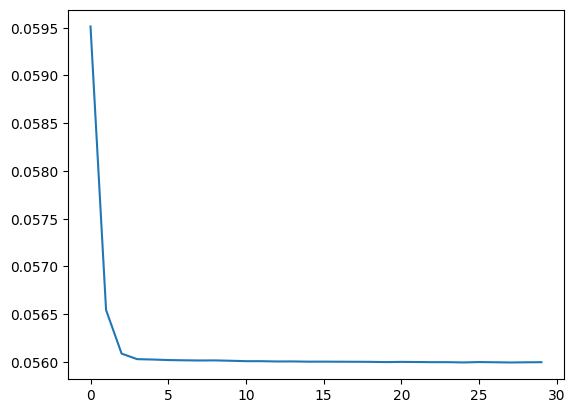

In [6]:
input_size = x_train_reshaped.shape[1]
code_size = 2


linear_ae, linear_encoder = linear_autoencoder(input_size, code_size)
linear_ae_history = linear_ae.fit(
    x_train_reshaped, x_train_reshaped, epochs=30, batch_size=32
)
history = linear_ae_history.history["loss"]
plt.plot(history, label="loss")


**Exercise 3:** Use the trained encoder to project the MNIST data to 2 features.

- Plot the two components in a scatter plot similar to the one we produced in [lab_session_10](https://adimajo.github.io/CSE204-2021/lab_session_10/lab_session_10.html) for PCA.
- How does the scatter plot compare to the one we made with PCA?

Recall that this autoencoder should learn the same vector space as PCA, though it will not learn the exact same transformation (could be rotated, scaled, etc.). Similarly to [lab_session_10](https://adimajo.github.io/CSE204-2021/lab_session_10/lab_session_10.html), you might want to draw fewer points to be able to see something.


32/32 [==============================] - 0s 584us/step


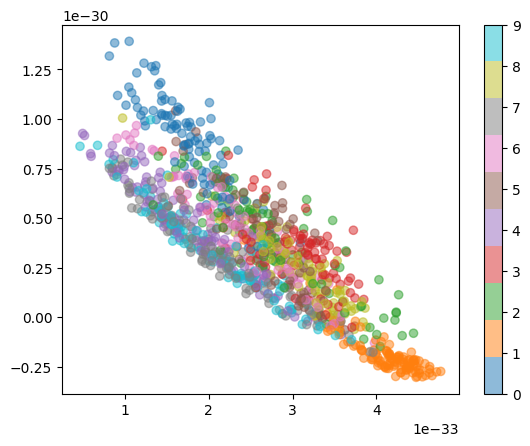

In [7]:
# ... linear_encoder...(...)  # <- TO UNCOMMENT AND COMPLETE
# plt.scatter(...)  # <- TO UNCOMMENT AND COMPLETE

# We keep into account linear_encoder is a KerasTensor and has no attribute predict
# We use the predict method of the linear_ae model

N_POINTS = 1000
plt.scatter(
    # linear_ae.predict(x_train_reshaped)[:, 0],
    linear_ae.predict(x_train_reshaped[:N_POINTS])[:, 0],
    linear_ae.predict(x_train_reshaped[:N_POINTS])[:, 1],
    c=y_train[:N_POINTS],
    cmap="tab10",
    alpha=0.5,
)
plt.colorbar()


As we can see, here the points are generally more cluttered and follow a diagonal line. This is because the autoencoder is not constrained to learn the same transformation as PCA. In fact, it is not even constrained to learn a linear transformation. Let's see what happens when we use a non-linear decoder.


### Undercomplete autoencoder: _nonlinear_ encoder and decoder

We saw in the previous section that linear decoders and MSE loss produce the same result as PCA. Therefore, we can see nonlinear encoders and decoders as a nonlinear generalization of PCA. By allowing nonlinear transformations, we should be able to increase the "expressiveness", or the quality of the representation / separation of our reduced variables.

**Exercise 4:** Create a nonlinear autoencoder.

- Copy your linear autoencoder function into `nonlinear_autoencoder`.
- Add a dense hidden layer in between the input layer and encoder output layer. Give the hidden layer `input_size` / 4 nodes and use ReLU activations for both the encoder and this additional hidden layer.
- Add a dense hidden layer in between the encoder output and decoder output layers. Give the hidden layer `input_size` / 4 nodes and use ReLU activations for this additional hidden layer.
- Keep the same optimizer and loss.


In [8]:
def nonlinear_autoencoder(input_size, code_size: int):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder

    :param int or tuple input_size: shape of the input samples
    :param int code_size: dimension on which to project the original data
    :return: autoencoder, encoder
    """

    input_layer = Input(shape=input_size)
    hidden_1 = Dense(input_size // 4, activation="relu")(input_layer)
    encoder = Dense(code_size, activation="relu")(hidden_1)
    hidden_2 = Dense(input_size // 4, activation="relu")(encoder)
    decoder = Dense(input_size, activation="relu")(hidden_2)
    autoencoder = Model(input_layer, decoder)
    autoencoder.compile(optimizer="adam", loss="mse")

    # use another `Model` which just takes the input and returns the output of the encoder layer (the encoder)
    encoder = Model(input_layer, encoder)

    return autoencoder, encoder

**Exercise 5:** Train the nonlinear autoencoder model.

- Create the nonlinear AE using 2 representation features as with the linear model.
- Train as before for at least 7 epochs and plot the loss history.


Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0646
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0558
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0521
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0504
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0488
Epoch 6/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0475
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0469
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0462
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0458
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0453
Epoch 11/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0447
Epoch 12/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0443
E

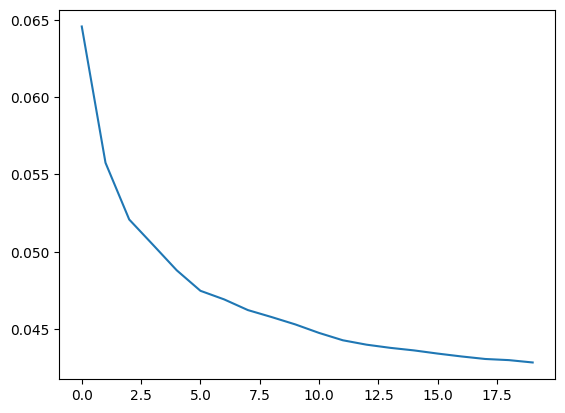

In [10]:
nonlinear_ae, nonlinear_encoder = nonlinear_autoencoder(input_size, code_size)
nonlinear_ae_history = nonlinear_ae.fit(
    x_train_reshaped, x_train_reshaped, epochs=20, batch_size=32
)
plt.plot(nonlinear_ae_history.history["loss"], label="loss")

**Exercise 6:** Plot the scatter plot of the reduced variables, that is, the samples projected onto the 2-dimensional code space (similar to Exercise 3).

- What can you say about grouping of points using the nonlinear model? Does it seem to cluster the digits better than with the linear one?


250/250 [==============================] - 0s 519us/step


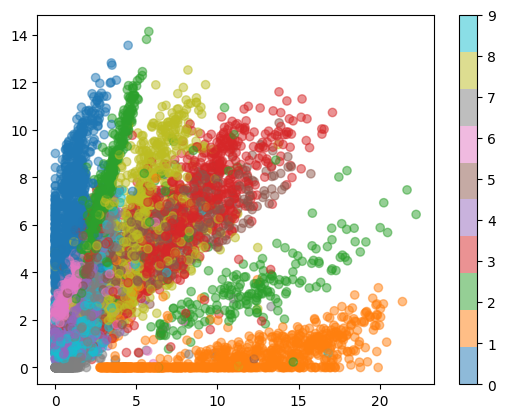

In [11]:
# ... nonlinear_encoder...(...)
# plt.scatter(...)  # <- TO UNCOMMENT AND COMPLETE

N_POINTS = 8000
plt.scatter(
    nonlinear_encoder.predict(x_train_reshaped[:N_POINTS])[:, 0],
    nonlinear_encoder.predict(x_train_reshaped[:N_POINTS])[:, 1],
    c=y_train[:N_POINTS],
    cmap="tab10",
    alpha=0.5,
)


plt.colorbar()


Yes, it seems to be clustering the points much better now. Instead of all of them being on the same diagonal, we can see that the points are now grouped by digit. This is because the nonlinear autoencoder is able to learn a more expressive representation of the data than the linear one. This is the main advantage of using a nonlinear autoencoder over PCA.


### Undercomplete autoencoder: Convolutional Neural Network encoder

In fact, we can use any deep learning layer we like in the encoder and decoder of an Autoencoder. Since the MNIST dataset is composed of image data, working with a CNN encoder is a reasonable choice, since it performed very well in a classification setting in [lab_session_09](https://adimajo.github.io/CSE204-2022-admin/lab_session_09.html). We will now implement such a model.

**Exercise 7:** Create a nonlinear autoencoder with a CNN encoder. In particular we want you to implement a deep learning architecture with the following layers:

- An input layer, which expects input of dimension image width, image height, number of image channels.
- A convolutional layer composed of 32 filters of dimension 3 by 3 with a ReLu activation function.
- A MaxPooling layer with a kernel size of 2 by 2.
- A layer which flattens the hidden representations.
- A Dense layer which maps the flattened representation to hidden representations of size `code_size`.
- A Dense layer that maps the code to hidden representations of size `output_size / 2`.
- A final Dense layer mapping the hidden representations of size `output_size / 2` to vectors of size `output_size`.
- Keep the same optimizer and loss from the previous architectures.


In [14]:
def nonlinear_autoencoder_with_cnn_encoder(
    input_width, input_height, input_channels, output_size, code_size: int
):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder

    :param int or tuple input_size: shape of the input samples
    :param int code_size: dimension on which to project the original data
    :return: autoencoder, encoder
    """

    # We create a nonlinear autoencoder and a CNN encoder
    input_layer = Input(shape=(input_width, input_height, input_channels))
    hidden_1 = Conv2D(32, (3, 3), activation="relu")(input_layer)
    hidden_2 = MaxPooling2D((2, 2))(hidden_1)
    hidden_3 = Flatten()(hidden_2)
    hidden_4 = Dense(code_size, activation="relu")(hidden_3)
    hidden_5 = Dense(output_size // 2, activation="relu")(hidden_4)
    output_layer = Dense(output_size, activation="relu")(hidden_5)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adam", loss="mse")

    # use another `Model` which just takes the input and returns the output of the encoder layer (the encoder)
    encoder = Model(input_layer, hidden_4)

    return autoencoder, encoder


**Exercise 8:** Train the autoencoder with a CNN encoder.

- Create the nonlinear AE with CNN encoder using 2 representation features (`code_size`) as with the linear and nonlinear dense models. Note that here the image width, height and number of channels (1 for gray scale images) need to be passed separately in the input. The output should correspond to vectors of size 784.
- Train as before for at least 7 epochs and plot the loss history.


In [24]:
x_train.shape


(60000, 28, 28)

Epoch 1/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0648
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0573
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0552
Epoch 4/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0539
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0532
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0522
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0516
Epoch 8/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0513
Epoch 9/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0511
Epoch 10/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0504
Epoch 11/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0498
Epoch 12/20
1875/1875 [==============================] - 10s 5ms/step - lo

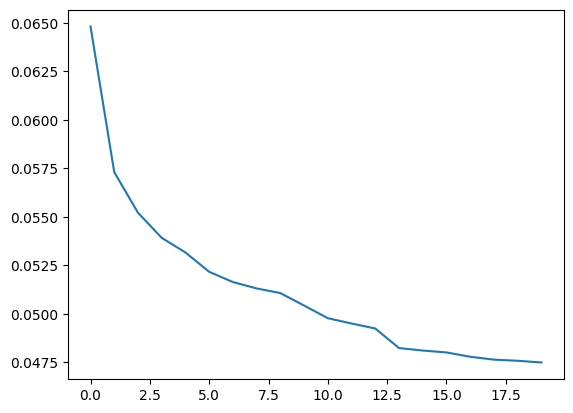

In [15]:
input_width = 28
input_height = 28
input_channels = 1
output_size = 784
code_size = 2

nonlinear_ae_cnn, nonlinear_encoder_cnn = nonlinear_autoencoder_with_cnn_encoder(
    input_width, input_height, input_channels, output_size, code_size
)
nonlinear_ae_cnn_history = nonlinear_ae_cnn.fit(
    x_train, x_train_reshaped, epochs=20, batch_size=32
)

plt.plot(nonlinear_ae_cnn_history.history["loss"], label="loss")

**Exercise 9:** Plot the scatter plot of the reduced variables (similar to Exercises 3 and 6).

- What can you say about grouping of points using the nonlinear model? Does it seem to cluster the digits better than with the linear one?


250/250 [==============================] - 0s 1ms/step


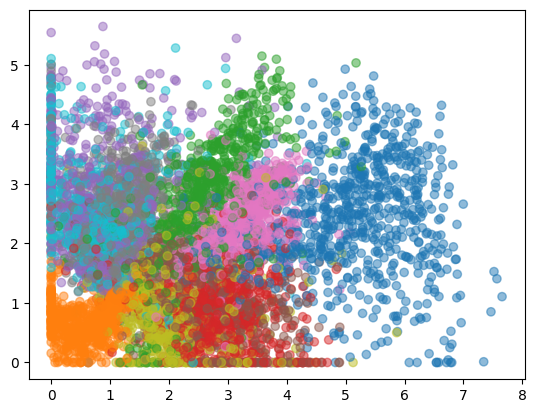

In [16]:
# ... nonlinear_encoder...(...)
# plt.scatter(...)  # <- TO UNCOMMENT AND COMPLETE

N_POINTS = 8000
plt.scatter(
    nonlinear_encoder_cnn.predict(x_train[:N_POINTS])[:, 0],
    nonlinear_encoder_cnn.predict(x_train[:N_POINTS])[:, 1],
    c=y_train[:N_POINTS],
    cmap="tab10",
    alpha=0.5,
)


Better clusters than the linear one. Although not much to say in respect with non-linear


**Exercise 10:** Calculate the number of parameters of the encoders defined in Exercises 4 and 7 and store them in the variables `nonlinear_encoder_number_of_parameters` and `nonlinear_encoder_cnn_number_of_parameters`, respectively.


In [17]:
nonlinear_encoder_number_of_parameters = nonlinear_encoder.count_params()
nonlinear_encoder_cnn_number_of_parameters = nonlinear_encoder_cnn.count_params()

154254

### Reconstruct Images

**Exercise 11:** Use the autoencoders to produce reconstructed images from the MNIST data as we did with PCA.

- Train linear, nonlinear and cnn encoder autoencoders on the MNIST data using a `code_size` of 15.
- Compare the loss histories of the training for both models on the same plot. What does this tell you about the expressiveness, i.e. the quality of the reconstruction of the two models?


Epoch 1/30
1875/1875 [==============================] - 2s 760us/step - loss: 0.0329
Epoch 2/30
1875/1875 [==============================] - 1s 710us/step - loss: 0.0285
Epoch 3/30
1875/1875 [==============================] - 1s 703us/step - loss: 0.0285
Epoch 4/30
1875/1875 [==============================] - 1s 683us/step - loss: 0.0285
Epoch 5/30
1875/1875 [==============================] - 1s 693us/step - loss: 0.0285
Epoch 6/30
1875/1875 [==============================] - 1s 741us/step - loss: 0.0285
Epoch 7/30
1875/1875 [==============================] - 1s 722us/step - loss: 0.0285
Epoch 8/30
1875/1875 [==============================] - 1s 772us/step - loss: 0.0284
Epoch 9/30
1875/1875 [==============================] - 1s 699us/step - loss: 0.0284
Epoch 10/30
1875/1875 [==============================] - 1s 779us/step - loss: 0.0284
Epoch 11/30
1875/1875 [==============================] - 1s 783us/step - loss: 0.0284
Epoch 12/30
1875/1875 [==============================] - 1s 709

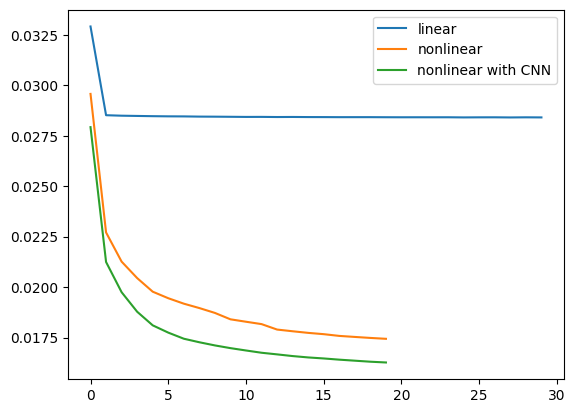

In [21]:
# Train autoencoder models, get history of losses
code_size = 15
linear_ae, linear_encoder = linear_autoencoder(input_size, code_size)
linear_ae_history = linear_ae.fit(
    x_train_reshaped, x_train_reshaped, epochs=30, batch_size=32
)
nonlinear_ae, nonlinear_encoder = nonlinear_autoencoder(input_size, code_size)
nonlinear_ae_history = nonlinear_ae.fit(
    x_train_reshaped, x_train_reshaped, epochs=20, batch_size=32
)
nonlinear_ae_cnn, nonlinear_encoder_cnn = nonlinear_autoencoder_with_cnn_encoder(
    input_width, input_height, input_channels, output_size, code_size
)
nonlinear_ae_cnn_history = nonlinear_ae_cnn.fit(
    x_train, x_train_reshaped, epochs=20, batch_size=32
)


# Plot the losses

plt.plot(linear_ae_history.history["loss"], label="linear")
plt.plot(nonlinear_ae_history.history["loss"], label="nonlinear")
plt.plot(nonlinear_ae_cnn_history.history["loss"], label="nonlinear with CNN")

plt.legend(["linear", "nonlinear", "nonlinear with CNN"])

Based on the results, it appears that the nonlinear model is the most effective, followed by the nonlinear model with convolutional neural networks (CNN), and lastly, the linear model. The nonlinear model outperforms the other models, which suggests that it is better at capturing the complexities and nuances of the data. The nonlinear model with CNN also performs well, indicating that the use of CNN in the model improves its accuracy. Lastly, the linear model is the least effective, implying that it may not be suitable for capturing the relationships and patterns present in the data.


Let's see what this will yield in terms of reconstruction quality / compression capability.


**Exercise 12:** Use the two AEs to produce reconstructed images (see [lab_session_10](https://adimajo.github.io/CSE204-2021/lab_session_10/lab_session_10.html)).

- Generate a grid of images
  - The first row should contain the first 5 images in the MNIST set as before.
  - The second row should contain their reconstruction using the linear model.
  - The third row should contain the reconstructions using the nonlinear model.
  - The fourth row should contain the reconstructions using the nonlinear model with a CNN encoder.
- How well do each of the models reproduce the images?
- How do they compare to the PCA reconstructions?

Recall from Exercise 11 that we used a `code_size` of 15, achieving a 784:15 $\approx$ 52:1 compression!


1/1 [==============================] - 0s 15ms/step


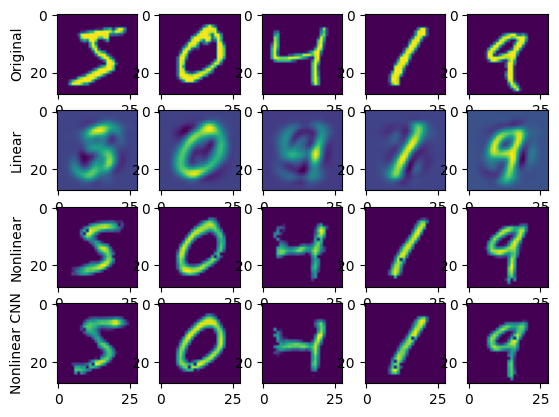

In [26]:
images = x_train[:5]  # the first 5 images
flat_images = x_train_reshaped[:5]

# linear
linear_results = linear_ae.predict(flat_images)
linear_results = linear_results.reshape((5, 28, 28))

# nonlinear
nonlinear_results = nonlinear_ae.predict(flat_images)
nonlinear_results = nonlinear_results.reshape((5, 28, 28))

# nonlinear cnn
nonlinear_cnn_results = nonlinear_ae_cnn.predict(images)
nonlinear_cnn_results = nonlinear_cnn_results.reshape((5, 28, 28))

# plot the images
fig, grid = plt.subplots(4, 5)

# plot the original ones first
for i in range(5):
    grid[0, i].imshow(images[i])


# plot linear reconstructions
for i in range(5):
    grid[1, i].imshow(linear_results[i])

# plot nonlinear reconstructions
for i in range(5):
    grid[2, i].imshow(nonlinear_results[i])

# plot nonlinear cnn reconstructions
for i in range(5):
    grid[3, i].imshow(nonlinear_cnn_results[i])

# We add labels to the rows
grid[0, 0].set_ylabel("Original")
grid[1, 0].set_ylabel("Linear")
grid[2, 0].set_ylabel("Nonlinear")
grid[3, 0].set_ylabel("Nonlinear CNN")
plt.show()


The linear model does not accurately replicate the images, while the other models perform relatively better. The latter models exhibit fewer pixelated areas and a wider range of color tones compared to the PCA reconstruction. This suggests that the other models are better at capturing the details and nuances of the images.
